In [1]:
import numpy as np
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.externals import joblib
from sklearn.metrics import r2_score, mean_squared_error
from math import sqrt
from numpy.random import seed
import matplotlib.pyplot as plt
import random
import time
from sklearn.utils import shuffle
import copy
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
import pickle
import pandas as pd

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
data_dir = 'drive/My Drive/rpt_project/rpt_data/4walls_materials_RawData/'
result_dir = 'drive/My Drive/rpt_project/rpt_data/results/'

calibration_points = 'drive/My Drive/rpt_project/rpt_data/old4walls_materials/r_10527_5M.mac'

data_files =  ['r_16_10527_5M_Air_Air_counts_RawData.txt',
               'r_16_10527_5M_AC_Air_counts_RawData.txt',
               'r_16_10527_5M_AC_Water_counts_RawData.txt',
               'r_16_10527_5M_AC_Glass_counts_RawData.txt',
               'r_16_10527_5M_AC_Steel_counts_RawData.txt',
               'r_16_10527_5M_AL_Air_counts_RawData.txt',
               'r_16_10527_5M_AL_Water_counts_RawData.txt',
               'r_16_10527_5M_AL_Glass_counts_RawData.txt',
               'r_16_10527_5M_AL_Steel_counts_RawData.txt',
               'r_16_10527_5M_SS_Air_counts_RawData.txt',
               'r_16_10527_5M_SS_Water_counts_RawData.txt',
               'r_16_10527_5M_SS_Glass_counts_RawData.txt']

num_tasks = len(data_files)

In [3]:
# Performance
def evaluate_performance(real, pred):
    diff_sq = (real - pred) ** 2
    mede = np.sum(np.sqrt(np.sum(diff_sq, axis=1))) / pred.shape[0]

    diff_abs = np.abs(real - pred)
    mae = np.sum(diff_abs, axis=0) / pred.shape[0]

    standard_deviation = np.std(diff_sq, axis=0)

    # r2 = r2_score(real, pred)
    # rmse = sqrt(mean_squared_error(real, pred))

    return mede, standard_deviation

In [4]:
def read_position_from_mac(calibration_file):
    """Read the positions of tracers from .mac file

    Args:
        calibration_file (str): Name of the file containing Geant4 macro.
    """
    simulated_positions = []
    for line in open(calibration_file):
        temp = line.split()
        if "/gun/position" in line:
            simulated_positions.append([float(temp[1]), float(temp[2]), float(temp[3])])
    simulated_positions = np.array(simulated_positions, dtype=float)
    return simulated_positions

In [5]:
def create_ann_model():

    layers = [256, 128, 128, 128, 3]

    NN_model = Sequential()

    # The Input Layer :
    NN_model.add(Dense(layers[0], kernel_initializer='normal', input_dim=16, activation='relu'))

    # The Hidden Layers :
    for i in range(1, len(layers)-1):
        NN_model.add(Dense(layers[i], kernel_initializer='normal', activation='relu'))

    # The Output Layer :
    NN_model.add(Dense(layers[-1], kernel_initializer='normal', activation='linear'))

    # Compile the network :
    NN_model.compile(loss='mean_squared_error', optimizer='adam')

    return NN_model

In [6]:
sample = 100
num_features = 16

In [ ]:
seed(2020)

In [ ]:
X_train_all, y_train_all = [], []
X_val_all, y_val_all = [], []
X_test_all, y_test_all = [], []

for i in range(num_tasks):
    train_data_file = data_dir + data_files[i]
    X_single = np.loadtxt(train_data_file, dtype=float)
    y_single = read_position_from_mac(calibration_points)
    X_single, y_single = shuffle(X_single, y_single)

    X_test = X_single[:2000]
    y_test = y_single[:2000]
    X_test_all.append(X_test)
    y_test_all.append(y_test)

    X_train = X_single[2000:]
    y_train = y_single[2000:]
    X_train_all.append(X_train)
    y_train_all.append(y_train)

    # X_val = X_single[9000:]
    # y_val = y_single[9000:]
    # X_val_all.append(X_val)
    # y_val_all.append(y_val)

In [ ]:
X_train_all = np.array(X_train_all).reshape(12*8527, 16)
# X_val_all = np.array(X_val_all).reshape(12*2527, 16)
X_test_all = np.array(X_test_all).reshape(12*2000, 16)

y_train_all = np.array(y_train_all).reshape(12*8527, 3)
# y_val_all = np.array(y_val_all).reshape(12*2527, 3)
y_test_all = np.array(y_test_all).reshape(12*2000, 3)

In [ ]:
with open('train_data.npy', 'wb') as f:
    np.save(f, X_train_all)

# with open('val_data.npy', 'wb') as f:
#     np.save(f, X_val_all)

with open('test_data.npy', 'wb') as f:
    np.save(f, X_test_all)

with open('train_label.npy', 'wb') as f:
    np.save(f, y_train_all)

# with open('val_label.npy', 'wb') as f:
#     np.save(f, y_val_all)

with open('test_label.npy', 'wb') as f:
    np.save(f, y_test_all)

In [ ]:
train_data_file = data_dir + data_files[0]
X_all = np.loadtxt(train_data_file, dtype=float)
y_all = read_position_from_mac(calibration_points)
X_all, y_all = shuffle(X_all, y_all)
X_cand, y_cand = X_all[:3000], y_all[:3000]
X_val, y_val = X_all[3000:5000], y_all[3000:5000]
X_test, y_test = X_all[5000:], y_all[5000:]

In [ ]:
X_train, y_train = shuffle(X_cand, y_cand)
X_train, y_train = X_train[:100], y_train[:100]
X_test, y_test = shuffle(X_test, y_test)
X_test, y_test = X_test[:1000], y_test[:1000]

reg_x = SVR(C=512, gamma=128, epsilon=0.0001220703125, kernel='rbf', tol=1e-4)
reg_y = SVR(C=128, gamma=256, epsilon=6.103515625e-05, kernel='rbf', tol=1e-4)
reg_z = SVR(C=1024, gamma=256, epsilon=0.000244140625, kernel='rbf', tol=1e-4)
reg_x.fit(X_train, y_train[:, 0])
reg_y.fit(X_train, y_train[:, 1])
reg_z.fit(X_train, y_train[:, 2])

In [ ]:
sample_df_train = pd.DataFrame(columns=['True', 'Pred', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
recons_x = reg_x.predict(X_train)
recons_y = reg_y.predict(X_train)
recons_z = reg_z.predict(X_train)
recons = np.stack((recons_x, recons_y, recons_z), axis=-1)

sample_df_train['True'] = y_train[:, 0]
sample_df_train['Pred'] = recons_x
for i in range(16):
    sample_df_train[i] = X_train[:, i]

In [ ]:
sample_df_test = pd.DataFrame(columns=['True', 'Pred', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])

In [ ]:
recons_x = reg_x.predict(X_test)
recons_y = reg_y.predict(X_test)
recons_z = reg_z.predict(X_test)
recons = np.stack((recons_x, recons_y, recons_z), axis=-1)

sample_df_test['True'] = y_test[:, 0]
sample_df_test['Pred'] = recons_x
for i in range(16):
    sample_df_test[i] = X_test[:, i]

In [ ]:
sample_df_test.shape

(1000, 18)

In [ ]:
all_df = sample_df_train.append(sample_df_test, ignore_index=True)

In [ ]:
all_df.head()

,True,Pred,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-0.084,-0.084147,0.009029,0.014085,0.010496,0.003902,0.005477,0.005778,0.006727,0.006281,0.003912,0.003321,0.003816,0.003188,0.001638,0.001138,0.004209,0.002515
1,-0.077,-0.076718,0.002783,0.004371,0.004809,0.001537,0.002369,0.002835,0.015116,0.008117,0.003711,0.006083,0.005461,0.003748,0.000755,0.000807,0.012486,0.004929
2,-0.077,-0.076688,0.003300,0.004934,0.004935,0.001811,0.002715,0.003103,0.017043,0.009924,0.004675,0.006191,0.006010,0.004256,0.000918,0.000997,0.008907,0.003957
3,-0.077,-0.077286,0.004070,0.007136,0.008839,0.002144,0.003352,0.004301,0.008307,0.005419,0.002841,0.004300,0.003930,0.002747,0.000664,0.000551,0.014364,0.005833
4,-0.007,-0.006760,0.006217,0.008968,0.007939,0.004539,0.007315,0.008432,0.008983,0.007776,0.004661,0.007399,0.008322,0.005982,0.001465,0.001425,0.005308,0.005040


In [ ]:
all_df.to_csv('feature_sample_z.csv')

In [7]:
with open(result_dir + 'train_data.npy', 'rb') as f:
    X_train_all = np.load(f)

with open(result_dir + 'val_data.npy', 'rb') as f:
    X_val_all = np.load(f)

with open(result_dir + 'test_data.npy', 'rb') as f:
    X_test_all = np.load(f)

with open(result_dir + 'train_label.npy', 'rb') as f:
    y_train_all = np.load(f)

with open(result_dir + 'val_label.npy', 'rb') as f:
    y_val_all = np.load(f)

with open(result_dir + 'test_label.npy', 'rb') as f:
    y_test_all = np.load(f)

In [ ]:
# BL&PT tuning
parameters = {'C':[4, 8, 64, 128, 256, 512, 1024], 
              'epsilon':[2**(-15), 2**(-14), 2**(-13), 2**(-12), 2**(-11)],
              'gamma': [128, 256, 512, 1024, 2048, 4096]}

pair_results = {}
X_val, y_val = X_val_all[:2527], y_val_all[:2527]

for c in parameters['C']:
   for epsilon in parameters['epsilon']:
       for gamma in parameters['gamma']:
          total_mede = []
          for i in range(1): 
              X_cand, y_cand = X_train_all[:3000], y_train_all[:3000]
              X_cand, y_cand = shuffle(X_cand, y_cand)
              X_train, y_train = X_cand[:sample], y_cand[:sample]

              reg_x = SVR(C=c, gamma=gamma, epsilon=epsilon, kernel='rbf', tol=1e-4)
              reg_y = SVR(C=c, gamma=gamma, epsilon=epsilon, kernel='rbf', tol=1e-4)
              reg_z = SVR(C=c, gamma=gamma, epsilon=epsilon, kernel='rbf', tol=1e-4)

              reg_x.fit(X_train, y_train[:, 0])
              reg_y.fit(X_train, y_train[:, 1])
              reg_z.fit(X_train, y_train[:, 2])

              pred_x = reg_x.predict(X_val)
              pred_y = reg_y.predict(X_val)
              pred_z = reg_z.predict(X_val)
              recons = np.stack((pred_x, pred_y, pred_z), axis=-1)

              mede, std = evaluate_performance(y_val, recons)
              total_mede.append(mede) 

          pair_results[(c, epsilon, gamma)] = total_mede

In [ ]:
# AI tuning
total_train = sample * 12

parameters = {'C':[256, 512, 1024, 2048, 4096], 
              'epsilon':[2**(-14), 2**(-13), 2**(-12)],
              'gamma': [16, 32, 64, 128, 256, 512]}

pair_results = {}
train_data, train_label = [], []

for i in range(12):
    X_cand, y_cand = X_train_all[3000*i:3000*(i+1)], y_train_all[3000*i:3000*(i+1)]
    X_cand, y_cand = shuffle(X_cand, y_cand)
    data, label = X_cand[:sample], y_cand[:sample]

    train_data.append(data)
    train_label.append(label)

X_train = np.array(train_data).reshape(total_train, num_features)
y_train = np.array(train_label).reshape(total_train, 3)

for c in parameters['C']:
   for epsilon in parameters['epsilon']:
       for gamma in parameters['gamma']:
          total_mede = []
          for i in range(1): 

              reg_x = SVR(C=c, gamma=gamma, epsilon=epsilon, kernel='rbf', tol=1e-4)
              reg_y = SVR(C=c, gamma=gamma, epsilon=epsilon, kernel='rbf', tol=1e-4)
              reg_z = SVR(C=c, gamma=gamma, epsilon=epsilon, kernel='rbf', tol=1e-4)

              reg_x.fit(X_train, y_train[:, 0])
              reg_y.fit(X_train, y_train[:, 1])
              reg_z.fit(X_train, y_train[:, 2])

              mede_arr = []
              for j in range(12):
                  X_val, y_val = X_val_all[2527*j:2527*(j+1)], y_val_all[2527*j:2527*(j+1)]
                  pred_x = reg_x.predict(X_val)
                  pred_y = reg_y.predict(X_val)
                  pred_z = reg_z.predict(X_val)
                  recons = np.stack((pred_x, pred_y, pred_z), axis=-1)

                  mede, std = evaluate_performance(y_val, recons)
                  mede_arr.append(mede) 

          total_mede.append(mede_arr)

          pair_results[(c, epsilon, gamma)] = total_mede

In [ ]:
len(pair_results)

210

In [ ]:
import pickle
with open('100_ai_tune.pkl', 'wb') as f:
      pickle.dump(pair_results, f)

In [ ]:
import pickle
with open('100_sample_tuning.pkl', 'rb') as f:
    pair_results = pickle.load(f)

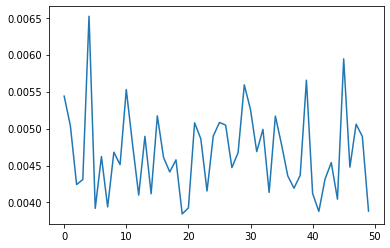

In [ ]:
plt.plot(pair_results[list(pair_results.keys())[4]])

In [ ]:
pair_avg = {}
pair_std = {}
for k in pair_results:
    pair_avg[k] = np.mean(pair_results[k])
    pair_std[k] = np.std(pair_results[k])

In [ ]:
min(pair_avg, key=pair_avg.get)

(512, 6.103515625e-05, 256)

In [ ]:
pair_avg[(16, 0.0001220703125, 2048)]

0.002030711086372986

In [ ]:
pair_avg[(64, 0.0001220703125, 1024)]

0.002059621052387776

In [ ]:
parameters = {'C':[2**(-3), 2**(-2), 2**(-1), 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024], 
              'epsilon':[2**(-16), 2**(-15), 2**(-14), 2**(-13), 2**(-12), 2**(-11), 2**(-10), 2**(-9)], 
              'gamma': [1, 2, 4, 8, 'scale', 16, 32, 64, 128, 256, 512, 1024]}

avg_mede = []
for epsilon in parameters['epsilon']:
   for gamma in parameters['gamma']:
      total_mede = []
      for i in range(50): 
          X_train, y_train = shuffle(X_cand, y_cand)
          X_train, y_train = X_train[:100], y_train[:100]

          reg_x = SVR(C=512, gamma=gamma, epsilon=epsilon, kernel='rbf', tol=1e-4)
          reg_y = SVR(C=512, gamma=gamma, epsilon=epsilon, kernel='rbf', tol=1e-4)
          reg_z = SVR(C=512, gamma=gamma, epsilon=epsilon, kernel='rbf', tol=1e-4)

          reg_x.fit(X_train, y_train[:, 0])
          reg_y.fit(X_train, y_train[:, 1])
          reg_z.fit(X_train, y_train[:, 2])

          pred_x = reg_x.predict(X_val)
          pred_y = reg_y.predict(X_val)
          pred_z = reg_z.predict(X_val)
          recons = np.stack((pred_x, pred_y, pred_z), axis=-1)

          mede, std = evaluate_performance(y_val, recons)
          total_mede.append(mede) 

      avg_mede.append(np.mean(total_mede))

In [ ]:
arr = np.array(avg_mede).reshape(8, 12)

Text(0.5, 40.5, 'Gamma')

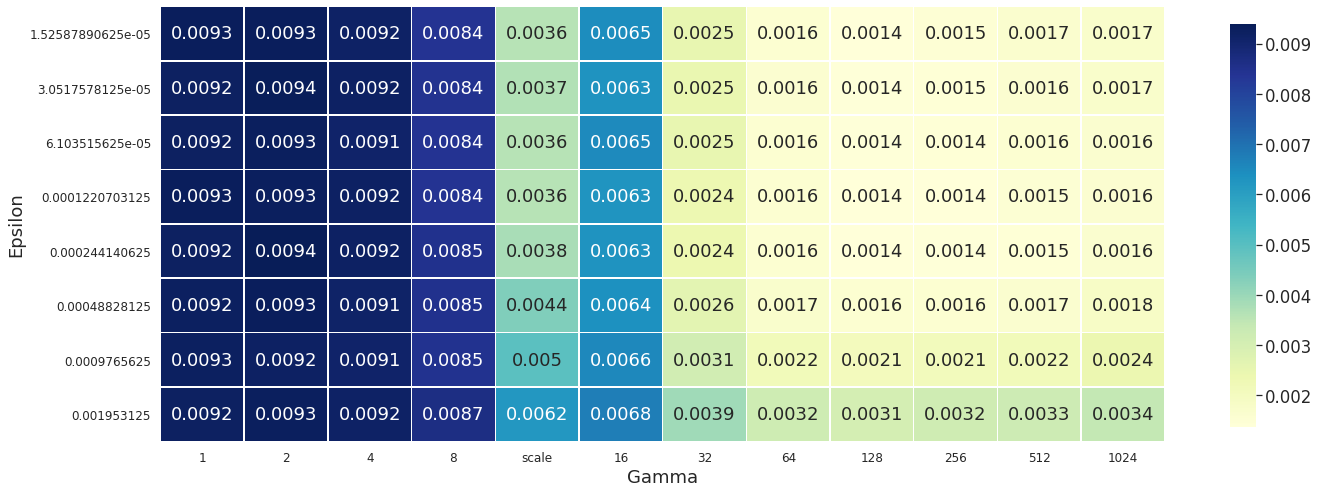

In [ ]:
import seaborn as sns
from matplotlib.colors import LogNorm

fig, ax = plt.subplots(figsize=(18, 8))
sns.set(font_scale=1.5)
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
sns_plot = sns.heatmap(arr, cmap='YlGnBu', annot=True, linewidths=0.5, 
                       vmin=np.min(arr), vmax=np.max(arr), ax=ax, cbar_ax=cbar_ax)

sns_plot.set_xticklabels(labels=parameters['gamma'], fontsize=12, rotation='horizontal')
sns_plot.set_yticklabels(labels=parameters['epsilon'], fontsize=12, rotation='horizontal')

# sns_plot.xaxis.tick_top()
ax.set_ylabel('Epsilon')
ax.set_xlabel('Gamma')

In [ ]:
X_train, y_train = X_cand[:1000], y_cand[:1000]

reg_x = SVR(kernel='rbf', tol=1e-4)
reg_y = SVR(kernel='rbf', tol=1e-4)
reg_z = SVR(kernel='rbf', tol=1e-4)

parameters = {'C':[2**(-6), 2**(-5), 2**(-4), 2**(-3), 2**(-2), 2**(-1), 1, 2, 4, 8, 16, 32, 64], 
              'epsilon':[2**(-14), 2**(-13), 2**(-12), 2**(-11), 2**(-10), 2**(-9), 2**(-8), 2**(-7)],
              'gamma': [2**(-3), 2**(-2), 2**(-1), 1, 2, 4, 8, 16, 32, 64, 128, 'scale']}

clf_x = GridSearchCV(reg_x, parameters)
clf_y = GridSearchCV(reg_y, parameters)
clf_z = GridSearchCV(reg_z, parameters)

clf_x.fit(X_train, y_train[:, 0])
clf_y.fit(X_train, y_train[:, 1])
clf_z.fit(X_train, y_train[:, 2])

print(clf_x.best_estimator_)
print(clf_y.best_estimator_)
print(clf_z.best_estimator_)

SVR(C=64, cache_size=200, coef0=0.0, degree=3, epsilon=6.103515625e-05,
    gamma=128, kernel='rbf', max_iter=-1, shrinking=True, tol=0.0001,
    verbose=False)
SVR(C=2, cache_size=200, coef0=0.0, degree=3, epsilon=6.103515625e-05,
    gamma='scale', kernel='rbf', max_iter=-1, shrinking=True, tol=0.0001,
    verbose=False)
SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.0001220703125,
    gamma='scale', kernel='rbf', max_iter=-1, shrinking=True, tol=0.0001,
    verbose=False)


In [8]:
parameters = {'C':[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096], 
              'epsilon':[2**(-20), 2**(-18), 2**(-16), 2**(-15), 2**(-14), 2**(-13), 2**(-12), 2**(-11), 2**(-10), 2**(-9)], 
              'gamma': [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]}

In [9]:
# Ablation plot tuning hyperparameters
epsilon_mede = []
epsilon_choices = parameters['epsilon']

for i in range(num_tasks):

    X_cand, y_cand = X_train_all[3000*i:3000*(i+1)], y_train_all[3000*i:3000*(i+1)]
    X_val, y_val = X_val_all[2527*i:2527*(i+1)], y_val_all[2527*i:2527*(i+1)]
    X_test, y_test = X_test_all[5000*i:5000*(i+1)], y_test_all[5000*i:5000*(i+1)]

    X_cand, y_cand = shuffle(X_cand, y_cand)
    X_train, y_train = X_cand[:sample], y_cand[:sample]

    m = []

    for k in epsilon_choices:

        reg_x = SVR(C=512, gamma=256, epsilon=k, kernel='rbf', tol=1e-4)
        reg_y = SVR(C=512, gamma=256, epsilon=k, kernel='rbf', tol=1e-4)
        reg_z = SVR(C=512, gamma=256, epsilon=k, kernel='rbf', tol=1e-4)
        reg_x.fit(X_train, y_train[:, 0])
        reg_y.fit(X_train, y_train[:, 1])
        reg_z.fit(X_train, y_train[:, 2])

        recons_x = reg_x.predict(X_val)
        recons_y = reg_y.predict(X_val)
        recons_z = reg_z.predict(X_val)
        recons = np.stack((recons_x, recons_y, recons_z), axis=-1)

        mede, std = evaluate_performance(y_val, recons)
        m.append(mede)

    epsilon_mede.append(m)
epsilon_result = np.mean(np.array(epsilon_mede), axis=0)

In [28]:
# Ablation plot tuning hyperparameters
c_mede = []
c_choices = parameters['C']

for i in range(num_tasks):

    X_cand, y_cand = X_train_all[3000*i:3000*(i+1)], y_train_all[3000*i:3000*(i+1)]
    X_val, y_val = X_val_all[2527*i:2527*(i+1)], y_val_all[2527*i:2527*(i+1)]
    X_test, y_test = X_test_all[5000*i:5000*(i+1)], y_test_all[5000*i:5000*(i+1)]

    X_cand, y_cand = shuffle(X_cand, y_cand)
    X_train, y_train = X_cand[:sample], y_cand[:sample]

    m = []

    for k in c_choices:

        reg_x = SVR(C=k, gamma=256, epsilon=2**(-13), kernel='rbf', tol=1e-4)
        reg_y = SVR(C=k, gamma=256, epsilon=2**(-13), kernel='rbf', tol=1e-4)
        reg_z = SVR(C=k, gamma=256, epsilon=2**(-13), kernel='rbf', tol=1e-4)
        reg_x.fit(X_train, y_train[:, 0])
        reg_y.fit(X_train, y_train[:, 1])
        reg_z.fit(X_train, y_train[:, 2])

        recons_x = reg_x.predict(X_test)
        recons_y = reg_y.predict(X_test)
        recons_z = reg_z.predict(X_test)
        recons = np.stack((recons_x, recons_y, recons_z), axis=-1)

        mede, std = evaluate_performance(y_test, recons)
        m.append(mede)

    c_mede.append(m)
c_result = np.mean(np.array(c_mede), axis=0)

In [29]:
# Ablation plot tuning hyperparameters
gamma_mede = []
gamma_choices = parameters['gamma']

for i in range(num_tasks):

    X_cand, y_cand = X_train_all[3000*i:3000*(i+1)], y_train_all[3000*i:3000*(i+1)]
    X_val, y_val = X_val_all[2527*i:2527*(i+1)], y_val_all[2527*i:2527*(i+1)]
    X_test, y_test = X_test_all[5000*i:5000*(i+1)], y_test_all[5000*i:5000*(i+1)]

    X_cand, y_cand = shuffle(X_cand, y_cand)
    X_train, y_train = X_cand[:sample], y_cand[:sample]

    m = []

    for k in gamma_choices:

        reg_x = SVR(C=512, gamma=k, epsilon=2**(-13), kernel='rbf', tol=1e-4)
        reg_y = SVR(C=512, gamma=k, epsilon=2**(-13), kernel='rbf', tol=1e-4)
        reg_z = SVR(C=512, gamma=k, epsilon=2**(-13), kernel='rbf', tol=1e-4)
        reg_x.fit(X_train, y_train[:, 0])
        reg_y.fit(X_train, y_train[:, 1])
        reg_z.fit(X_train, y_train[:, 2])

        recons_x = reg_x.predict(X_test)
        recons_y = reg_y.predict(X_test)
        recons_z = reg_z.predict(X_test)
        recons = np.stack((recons_x, recons_y, recons_z), axis=-1)

        mede, std = evaluate_performance(y_test, recons)
        m.append(mede)

    gamma_mede.append(m)
gamma_result = np.mean(np.array(gamma_mede), axis=0)

In [ ]:
# Ablation plot tuning hyperparameters
kernel_mede = []
kernel_choices = ['linear', 'poly', 'rbf', 'sigmoid']

for i in range(num_tasks):

    X_cand, y_cand = X_train_all[3000*i:3000*(i+1)], y_train_all[3000*i:3000*(i+1)]
    X_val, y_val = X_val_all[2527*i:2527*(i+1)], y_val_all[2527*i:2527*(i+1)]
    X_test, y_test = X_test_all[5000*i:5000*(i+1)], y_test_all[5000*i:5000*(i+1)]

    X_cand, y_cand = shuffle(X_cand, y_cand)
    X_train, y_train = X_cand[:sample], y_cand[:sample]

    m = []

    for k in kernel_choices:

        reg_x = SVR(C=512, gamma=256, epsilon=2**(-13), kernel=k, tol=1e-4)
        reg_y = SVR(C=512, gamma=256, epsilon=2**(-13), kernel=k, tol=1e-4)
        reg_z = SVR(C=512, gamma=256, epsilon=2**(-13), kernel=k, tol=1e-4)

        reg_x.fit(X_train, y_train[:, 0])
        reg_y.fit(X_train, y_train[:, 1])
        reg_z.fit(X_train, y_train[:, 2])

        recons_x = reg_x.predict(X_test)
        recons_y = reg_y.predict(X_test)
        recons_z = reg_z.predict(X_test)
        recons = np.stack((recons_x, recons_y, recons_z), axis=-1)

        mede, std = evaluate_performance(y_test, recons)
        m.append(mede)

    kernel_mede.append(m)
kernel_result = np.mean(np.array(kernel_mede), axis=0)

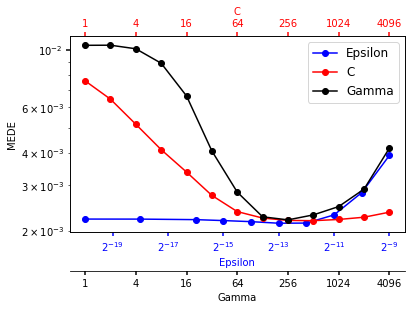

In [30]:
from matplotlib.ticker import MaxNLocator
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

fig, host = plt.subplots()
fig.subplots_adjust(bottom=0.2)

par1 = host.twiny()
par2 = host.twiny()
# par3 = host.twiny()

# Offset the right spine of par2.  The ticks and label have already been
# placed on the right by twinx above.
par2.spines["bottom"].set_position(("axes", -0.2))
make_patch_spines_invisible(par2)
# Second, show the right spine.
par2.spines["bottom"].set_visible(True)

# par3.spines["bottom"].set_position(("axes", -0.4))
# make_patch_spines_invisible(par3)
# # Second, show the right spine.
# par3.spines["bottom"].set_visible(True)

p1, = host.plot(epsilon_choices, epsilon_result, "bo-", label="Epsilon")
p2, = par1.plot(c_choices, c_result, "ro-", label="C")
# p3, = par2.plot(tol_choices, tol_result, "go-", label="Tolerance")
p3, = par2.plot(gamma_choices, gamma_result, "ko-", label="Gamma")

# host.set_xlim(1e-6, 10)
# host.set_ylim(0.5, 100)
# par1.set_xlim(1e-4, 1000)
# par2.set_xlim(1e-6, 10)

host.set_xlabel("Epsilon")
host.set_ylabel("MEDE")
par1.set_xlabel("C")
par2.set_xlabel("Gamma")
# par3.set_xlabel("Kernel")

host.set_xscale('log', basex=2)
par1.set_xscale('log', basex=2)
par2.set_xscale('log', basex=2)

host.xaxis.label.set_color(p1.get_color())
par1.xaxis.label.set_color(p2.get_color())
par2.xaxis.label.set_color(p3.get_color())
# par3.xaxis.label.set_color(p4.get_color())

par2.xaxis.set_ticks_position("bottom")
par2.xaxis.set_label_position("bottom")

# par3.xaxis.set_ticks_position("bottom")
# par3.xaxis.set_label_position("bottom")

# host.set_xticklabels(epsilon_choices)
# par1.set_xticklabels(c_choices)
# par2.set_xticklabels(tol_choices)

tkw = dict(size=4, width=1.5)
host.tick_params(axis='x', colors=p1.get_color(), **tkw)
par1.tick_params(axis='x', colors=p2.get_color(), **tkw)
par2.tick_params(axis='x', colors=p3.get_color(), **tkw)
# par3.tick_params(axis='x', colors=p4.get_color(), **tkw)
host.tick_params(axis='y', **tkw)

lines = [p1, p2, p3]

host.legend(lines, [l.get_label() for l in lines], loc='upper right', fontsize='large')

host.set_yscale('log')

# host.set_xticks([2**(-20), 2**(-18), 2**(-16), 2**(-14), 2**(-12), 2**(-10)])
# host.set_xticklabels([2**(-20), 2**(-18), 2**(-16), 2**(-14), 2**(-12), 2**(-10)])
# host.ticklabel_format(useOffset=False)
par1.set_xticks([1, 4, 16, 64, 256, 1024, 4096])
par1.set_xticklabels([1, 4, 16, 64, 256, 1024, 4096])
par2.set_xticks([1, 4, 16, 64, 256, 1024, 4096])
par2.set_xticklabels([1, 4, 16, 64, 256, 1024, 4096])

fig.savefig('sensitivity_100.pdf', dpi=300, bbox_inches = 'tight')

plt.show()

In [ ]:
lr_choices = [1e-2, 1e-3, 1e-4, 1e-5]
lr_accuracy = [0.879, 0.762, 0.804, 0.874]
lr_f1 = [0, 0.092, 0.38, 0.016]
lr_iou = [0, 0.048, 0.235, 0.008]

In [ ]:
e_choices = [10, 20, 30, 50, 100]
e_accuracy = [0.804, 0.828, 0.630, 0.745, 0.791]
e_f1 = [0.38, 0.271, 0.355, 0.435, 0.315]
e_iou = [0.235, 0.157, 0.216, 0.278, 0.187]

In [ ]:
filter_choices = ['(8,16,32,64,128)', '(16,32,64,128,256)', '(32,64,128,256,512)', '(64,128,256,512,1024)']
filter_accuracy = [0.841, 0.804, 0.563, 0.879]
filter_f1 = [0.045, 0.38, 0.268, 0.133]
filter_iou = [0.023, 0.235, 0.155, 0.071]

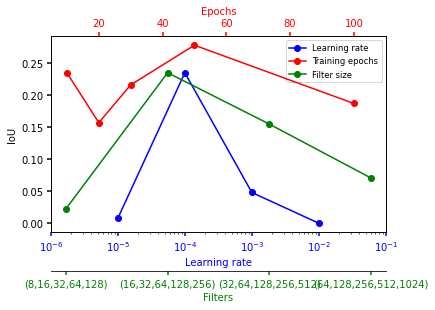

In [ ]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

fig, host = plt.subplots()
fig.subplots_adjust(bottom=0.2)

par1 = host.twiny()
par2 = host.twiny()

# Offset the right spine of par2.  The ticks and label have already been
# placed on the right by twinx above.
par2.spines["bottom"].set_position(("axes", -0.2))
make_patch_spines_invisible(par2)
# Second, show the right spine.
par2.spines["bottom"].set_visible(True)

# par3.spines["bottom"].set_position(("axes", -0.4))
# make_patch_spines_invisible(par3)
# # Second, show the right spine.
# par3.spines["bottom"].set_visible(True)

# print(host.plot(filter_choices, filter_accuracy, "go-", label="Filter size"))

p1, = host.plot(lr_choices, np.array(lr_iou), "bo-", label="Learning rate")
p2, = par1.plot(e_choices, np.array(e_iou), "ro-", label="Training epochs")
p3, = par2.plot(filter_choices, np.array(filter_iou), "go-", label="Filter size")

host.set_xlim(1e-6, 1e-1)
# host.set_ylim(0.5, 1)
par1.set_xlim(5, 110)
#par2.set_xlim(1, 5)

host.set_xlabel("Learning rate")
par1.set_xlabel("Epochs")
par2.set_xlabel("Filters")

host.set_ylabel("IoU")


host.set_xscale('log')
# par1.set_xscale('log')
# par2.set_xscale('log')

host.xaxis.label.set_color(p1.get_color())
par1.xaxis.label.set_color(p2.get_color())
par2.xaxis.label.set_color(p3.get_color())

par2.xaxis.set_ticks_position("bottom")
par2.xaxis.set_label_position("bottom")

# host.set_xticklabels(epsilon_choices)
# par1.set_xticklabels(c_choices)
# par2.set_xticklabels(tol_choices)

tkw = dict(size=4, width=1.5)
host.tick_params(axis='x', colors=p1.get_color(), **tkw)
par1.tick_params(axis='x', colors=p2.get_color(), **tkw)
par2.tick_params(axis='x', colors=p3.get_color(), **tkw)
host.tick_params(axis='y', **tkw)

lines = [p1, p2, p3]

host.legend(lines, [l.get_label() for l in lines], loc='upper right', fontsize='small')

# host.set_yscale('log')

fig.savefig('scratch_iou.pdf', dpi=300, bbox_inches = 'tight')

plt.show()

In [ ]:
# SVR PT and BL experiments
mede_arr, r2_arr, rmse_arr = [], [], []
for i in range(num_tasks):

    X_train, y_train = X_all[i], y_all[i]
    X_train, y_train = shuffle(X_train, y_train)
    X_train = X_train[:sample]
    y_train = y_train[:sample]

    m, r, s = [], [], []

    for j in range(num_tasks):
        test_name = data_files[j].split('_')[4] + '_' + data_files[j].split('_')[5]
        X_test = np.loadtxt(test_data_file, dtype=float)
        y_test = read_position_from_mac(calibration_points)

        # reg_x = SVR(C=1, gamma='scale', epsilon=1e-4, kernel='rbf', tol=1e-4)
        # reg_y = SVR(C=1, gamma='scale', epsilon=1e-4, kernel='rbf', tol=1e-4)
        # reg_z = SVR(C=1, gamma='scale', epsilon=1e-4, kernel='rbf', tol=1e-4)

        reg_x = SVR(C=10, gamma='scale', epsilon=1e-5, kernel='rbf', tol=1e-6)
        reg_y = SVR(C=1000, gamma='scale', epsilon=0.01, kernel='linear', tol=1e-4)
        reg_z = SVR(C=10, gamma='scale', epsilon=1e-5, kernel='rbf', tol=1e-6)

        reg_x.fit(X_train, y_train[:, 0])
        reg_y.fit(X_train, y_train[:, 1])
        reg_z.fit(X_train, y_train[:, 2])

        recons_x = reg_x.predict(X_test)
        recons_y = reg_y.predict(X_test)
        recons_z = reg_z.predict(X_test)
        recons = np.stack((recons_x, recons_y, recons_z), axis=-1)
        
        mede, r2, rmse = evaluate_performance(y_test, recons)
        m.append(mede)
        r.append(r2)
        s.append(rmse)

    mede_arr.append(m)
    r2_arr.append(r)
    rmse_arr.append(s)

In [ ]:
with open('100_sample_tuning_x.pkl', 'rb') as f:
    dx = pickle.load(f)
with open('100_sample_tuning_y.pkl', 'rb') as f:
    dy = pickle.load(f)
with open('100_sample_tuning_z.pkl', 'rb') as f:
    dz = pickle.load(f)

In [ ]:
dx_avg, dy_avg, dz_avg = {}, {}, {}
for k in dx:
    dx_avg[k] = np.mean(dx[k])
for k in dy:
    dy_avg[k] = np.mean(dy[k])
for k in dz:
    dz_avg[k] = np.mean(dz[k])
print(min(dx_avg, key=dx_avg.get))
print(min(dy_avg, key=dy_avg.get))
print(min(dz_avg, key=dz_avg.get))

(512, 0.0001220703125, 128)
(128, 6.103515625e-05, 256)
(1024, 0.000244140625, 256)


In [ ]:
import pandas as pd
df = pd.DataFrame()

In [ ]:
for k in dz:
    row = []
    all_mede = dz[k]
    avg = np.mean(all_mede) * 1000
    std = np.std(all_mede) * 1000
    row.append(k[0])
    row.append(k[1])
    row.append(k[2])
    row.append(avg)
    row.append(std)
    row += [1000*x for x in all_mede]
    df = df.append([row], ignore_index=True)

In [ ]:
df.columns = ['C', 'epsilon', 'gamma', 'avg_mede', 'std_mede'] + list(np.arange(50))

In [ ]:
df.head()

,C,epsilon,gamma,avg_mede,std_mede,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,0.125,0.000015,1,51.176713,0.969324,51.257054,51.089556,50.773053,50.902001,56.054609,50.880127,50.898024,50.809154,50.577074,50.520828,51.347221,50.777971,51.650716,51.409590,51.353433,51.839348,50.639447,50.778057,50.594655,51.282020,51.341844,50.922408,50.775639,50.726601,54.689074,50.757250,50.763270,51.337790,50.608619,51.309845,50.594488,50.577046,51.675323,50.705821,50.592204,51.347618,50.528607,51.624093,51.272943,50.533591,51.348068,52.403346,50.583093,50.766530,50.551739,50.600025,51.402034,50.595641,51.884353,50.582827
1,0.125,0.000015,2,50.490178,0.519590,50.234964,50.208958,50.008608,50.711802,50.384959,50.185297,50.425267,50.765304,50.136093,50.432488,50.733593,50.183145,52.517351,50.410424,50.048266,52.459692,50.203953,50.771846,50.817403,50.098787,50.491193,50.735637,50.721546,50.082140,51.132874,50.314790,50.199441,51.217125,50.779718,50.034609,50.800872,50.189242,49.991570,50.842188,50.055812,50.158546,50.359224,51.076635,50.115549,50.237998,50.134460,50.252232,50.858218,50.193200,50.779031,50.335384,50.293878,50.116136,50.141600,50.129856
2,0.125,0.000015,4,49.540549,0.714017,49.321311,49.193383,49.236820,50.091095,49.852447,49.065996,49.825754,48.961683,49.008926,49.067481,48.943883,49.081604,50.105596,48.930946,49.074667,50.281285,51.170916,48.990404,48.917363,49.269654,52.116728,50.919448,49.205800,49.171085,49.125085,49.277820,49.755066,49.551657,49.482766,49.193325,50.097767,49.266856,49.053996,49.009927,49.226794,49.698087,49.346910,51.077094,48.960649,50.729250,49.104759,49.290617,49.987155,49.367308,49.044735,49.098556,51.084594,49.309471,49.087985,48.994966
3,0.125,0.000015,8,47.505360,0.733272,46.630920,48.883569,47.198089,49.426580,47.795627,48.730868,48.656630,48.144823,49.541605,47.495193,47.071934,47.366116,46.770564,47.240828,46.930582,47.917730,47.293576,47.825541,48.140308,48.974781,46.627985,47.015084,47.443198,46.714766,47.000424,47.860989,47.900758,46.936905,46.652595,46.668470,47.315105,46.925797,47.053870,48.254319,46.943963,47.040146,47.742757,47.026072,47.251945,47.455797,46.884168,47.516070,47.365302,47.122799,47.003248,46.909591,48.684431,47.340644,46.887143,47.687771
4,0.125,0.000015,scale,3.366804,0.445849,3.323951,3.253120,3.080123,4.106384,3.471466,3.307632,3.711118,3.495333,3.115594,4.200484,3.322559,2.893074,3.599454,4.209816,3.548707,3.850882,3.563232,3.733947,3.243931,3.408458,3.309020,2.734204,3.447026,2.741021,3.162987,4.090023,3.198563,2.985047,2.593736,2.713247,3.918386,3.142546,3.447269,3.290934,2.366690,2.809408,3.826277,2.818392,3.873888,2.817830,3.489740,3.515333,3.450992,4.360401,3.508978,3.400141,3.194825,3.582179,2.666313,3.445531


In [ ]:
df.to_csv('z_tuning.csv')

In [ ]:
X_test

array([[0.0119924, 0.0080112, 0.0041748, ..., 0.0058722, 0.0009154,
        0.0007892],
       [0.0149522, 0.008177 , 0.0038484, ..., 0.0058514, 0.0007444,
        0.00085  ],
       [0.0051962, 0.0054326, 0.0037992, ..., 0.003176 , 0.0025138,
        0.0018764],
       ...,
       [0.0038952, 0.0057908, 0.0058544, ..., 0.0007886, 0.0087302,
        0.0044722],
       [0.004537 , 0.0032784, 0.0019996, ..., 0.0149356, 0.000579 ,
        0.0006736],
       [0.003359 , 0.0034858, 0.0026112, ..., 0.0035962, 0.00185  ,
        0.002069 ]])

In [ ]:
with open('X_test.npy', 'wb') as f:
    np.save(f, X_test)

In [ ]:
with open('y_test.npy', 'wb') as f:
    np.save(f, y_test)

In [32]:
samples = [20, 50, 100, 500, 1000, 5000]
best_c = [2048, 1024, 512, 64, 64, 8]
best_gamma = [512, 128, 256, 1024, 1024, 4096]
best_epsilon = [2**(-15), 2**(-14), 2**(-13), 2**(-14), 2**(-13), 2**(-13)]

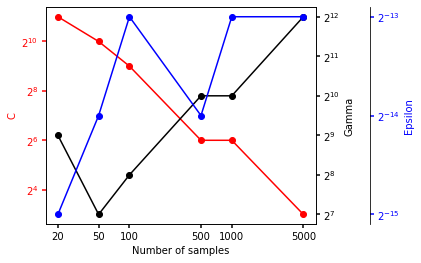

In [34]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)


fig, host = plt.subplots()
fig.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()

# Offset the right spine of par2.  The ticks and label have already been
# placed on the right by twinx above.
par2.spines["right"].set_position(("axes", 1.2))
# Having been created by twinx, par2 has its frame off, so the line of its
# detached spine is invisible.  First, activate the frame but make the patch
# and spines invisible.
make_patch_spines_invisible(par2)
# Second, show the right spine.
par2.spines["right"].set_visible(True)

p1, = host.plot(samples, best_c, "ro-", label="C")
p2, = par1.plot(samples, best_gamma, "ko-", label="Gamma")
p3, = par2.plot(samples, best_epsilon, "bo-", label="Epsilon")

# host.set_xlim(0, 2)
# host.set_ylim(0, 2)
# par1.set_ylim(0, 4)
# par2.set_ylim(1, 65)

host.set_xlabel("Number of samples")
host.set_ylabel("C")
par1.set_ylabel("Gamma")
par2.set_ylabel("Epsilon")

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
par2.yaxis.label.set_color(p3.get_color())

tkw = dict(size=4, width=1.5)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
par2.tick_params(axis='y', colors=p3.get_color(), **tkw)
host.tick_params(axis='x', **tkw)

host.set_xscale('log', basex=2)
host.set_yscale('log', basey=2)
par1.set_yscale('log', basey=2)
par2.set_yscale('log', basey=2)

lines = [p1, p2, p3]

host.set_xticks(samples)
host.set_xticklabels(['20', '50', '100', '500', '1000', '5000'])

# host.legend(lines, [l.get_label() for l in lines])
fig.savefig('ablation_plot.pdf', dpi=300)
plt.show()